<a href="https://colab.research.google.com/github/pranavchokda/ml-sandbox/blob/main/Colab_notebooks/Visualizing_attention_maps_of_LLM_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing attention maps of LLM  layers

This is an notebook is meant for experimenting with attention maps, to try out concepts mentioned in https://github.com/voidism/Lookback-Lens and https://github.com/voidism/DoLa

In [1]:
# Install libraries
!pip install -U --quiet transformers accelerate bitsandbytes inspectus

In [2]:
# Project variables
HF_MODEL_NAME="unsloth/gemma-3-1b-it-bnb-4bit"
COMPUTE_DEVICE="cuda"

In [3]:
# Imports
from transformers import AutoTokenizer, AutoModelForCausalLM
import inspectus
import torch

> # 🗒 Info
> Please make sure you change the runtime to T4 GPU

In [4]:
# Test if cuda is available if not notify the user

if torch.cuda.is_available():
    print("CUDA is available.")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    from google.colab import output
    output.eval_js('alert("CUDA is not available please change runtime type to GPU")')
    raise TypeError("Please select a GPU instance type to continue!")

CUDA is available.
Number of GPUs available: 1
GPU Name: Tesla T4


### Loading tokenizer and the model weights using transformers library from HF model registry

In [5]:
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME, device_map=COMPUTE_DEVICE, attn_implementation="eager")
model =  AutoModelForCausalLM.from_pretrained(HF_MODEL_NAME, device_map=COMPUTE_DEVICE, attn_implementation="eager")
text = ["The secret to baking a good cake is"]
model_inputs = tokenizer(text=text, return_tensors="pt").to("cuda")


generated_ids = model.generate(**model_inputs, max_length=128)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
# Generate outputs and access attention weights
# Ensure output_attentions=True when generating output
output = model(**model_inputs, output_attentions=True, return_dict=True)

In [7]:
# define visualization parameters
layer_idx = -1  # Last layer
head_idx = 0 #0    # First attention head

attention_weights = output.attentions[layer_idx][0, head_idx, :, :]

### Plotting attention map using matplotlib and seaborn

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
tokens = tokenizer.convert_ids_to_tokens(model_inputs["input_ids"][0])

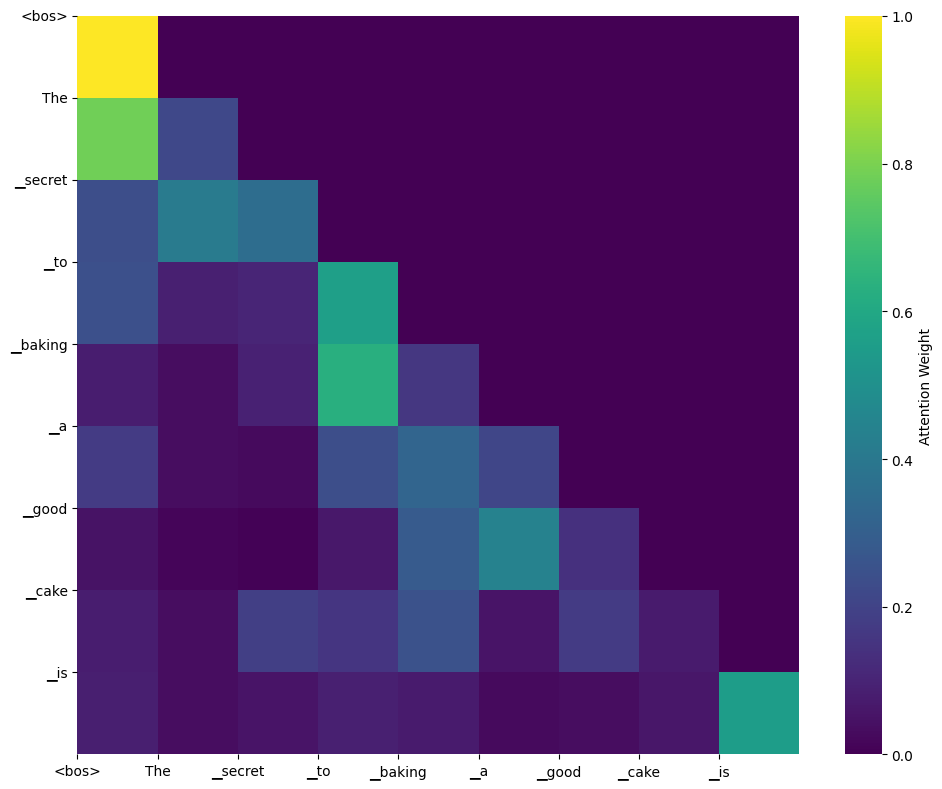

In [10]:
# 4. Create and display the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
cpu_attn = attention_weights.cpu().detach().numpy()
sns.heatmap(cpu_attn, xticklabels=model_inputs, yticklabels=model_inputs, cmap="viridis", annot=False,
            cbar_kws={"label": "Attention Weight"}, ax=ax)  # Plot the heatmap using seaborn
# plt.title(f"Attention Matrix (Layer {layer_idx+1}, Head {head_idx+1})")  # Add a title to the heatmap

plt.xticks(range(len(tokens)), tokens, rotation=0)
plt.yticks(range(len(tokens)), tokens)
#plt.xlabel("Key Tokens")  # Label for the x-axis
#plt.ylabel("Query Tokens")  # Label for the y-axis
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()  # Display the heatmap

### Plotting attention map using Inspectus

In [11]:
## INSPECTUS
import inspectus

# Initialize the tokenizer and model
context_length = 128

text = "Most important ingredient for macaron is "
tokenized = tokenizer(
    text,
    return_tensors='pt',
    return_offsets_mapping=True
)
input_ids = tokenized['input_ids']

tokens = [text[s: e] for s, e in tokenized['offset_mapping'][0]]

with torch.no_grad():
    res = model(input_ids=input_ids.to(model.device), output_attentions=True)

# Visualize the attention maps using the Inspectus library
inspectus.attention(res['attentions'], tokens)

In [12]:
inspectus.attention(res['attentions'], tokens,
          chart_types=['attention_matrix', 'query_token_heatmap', 'key_token_heatmap', 'dimension_heatmap', 'token_dim_heatmap', 'line_grid']
             ,color={
                 'query_token_heatmap': 'orange',
                 'key_token_heatmap': 'green',
                 'token_dim_heatmap': 'red',
             }
         )